In [2]:
!pip install catboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [5]:
# Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [6]:
# Load the dataset
try:
    df = pd.read_csv('CarDetails_105k.csv')
except FileNotFoundError:
    print("File not found.")


In [7]:
print("Original shape: {}".format(df.shape))
df.info()
df.describe()


Original shape: (105000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           105000 non-null  object 
 1   year           105000 non-null  int64  
 2   selling_price  105000 non-null  int64  
 3   km_driven      105000 non-null  int64  
 4   fuel           105000 non-null  object 
 5   seller_type    105000 non-null  object 
 6   transmission   105000 non-null  object 
 7   owner          105000 non-null  object 
 8   mileage        102141 non-null  object 
 9   engine         102141 non-null  object 
 10  max_power      102219 non-null  object 
 11  torque         102128 non-null  object 
 12  seats          102141 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 10.4+ MB


,year,selling_price,km_driven,seats
count,105000.000000,1.050000e+05,1.050000e+05,102141.000000
mean,2013.804143,6.382064e+05,6.981681e+04,5.417168
std,4.043242,8.078600e+05,5.696321e+04,0.960001
min,1983.000000,2.644900e+04,0.000000e+00,2.000000
25%,2011.000000,2.575095e+05,3.375775e+04,5.000000
50%,2015.000000,4.466560e+05,6.203850e+04,5.000000
75%,2017.000000,6.767920e+05,9.526000e+04,5.000000
max,2020.000000,1.066468e+07,2.617890e+06,14.000000


Data Cleaning and Feature Engineering

In [8]:
# Check for missing values and duplicates before handling them
print("\nMissing values before cleaning:\n", df.isnull().sum())
print("\nDuplicate rows before cleaning: ", df.duplicated().sum())


Missing values before cleaning:
 name                0
year                0
selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage          2859
engine           2859
max_power        2781
torque           2872
seats            2859
dtype: int64

Duplicate rows before cleaning:  0


In [10]:
# Handle duplicates and missing values
# df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [11]:
# Clean text from numerical columns
df['mileage'] = df['mileage'].str.replace(' kmpl', '', regex=False).str.replace(' km/kg', '', regex=False).astype(float)
df['engine'] = df['engine'].str.replace(' CC', '', regex=False).astype(float)
df['max_power'] = df['max_power'].str.replace(' bhp', '', regex=False).astype(float)

In [12]:
# Create 'brand' feature
df['brand'] = df['name'].str.split().str[0]

In [13]:
# Manual Label Encoding
df['fuel'].replace(['Diesel', 'Petrol', 'LPG', 'CNG'], [1, 2, 3, 4], inplace=True)
df['seller_type'].replace(['Individual', 'Dealer', 'Trustmark Dealer'], [1, 2, 3], inplace=True)
df['transmission'].replace(['Manual', 'Automatic'], [1, 2], inplace=True)
df['owner'].replace(['First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner', 'Test Drive Car'], [1, 2, 3, 4, 5], inplace=True)

/tmp/ipython-input-240879851.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fuel'].replace(['Diesel', 'Petrol', 'LPG', 'CNG'], [1, 2, 3, 4], inplace=True)
/tmp/ipython-input-240879851.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fuel'].replace(['Diesel', 'Petrol', 'LPG', 'CNG'], 

In [14]:
# Dynamically create brand mapping
unique_brands = df['brand'].unique()
brand_mapping = {}
for i, brand in enumerate(unique_brands):
    brand_mapping[brand] = i + 1
df['brand'].replace(brand_mapping, inplace=True)

print("Data cleaning and feature engineering complete.")
print("Final shape: {}".format(df.shape))

/tmp/ipython-input-628076221.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['brand'].replace(brand_mapping, inplace=True)


Data cleaning and feature engineering complete.
Final shape: (102128, 14)


/tmp/ipython-input-628076221.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['brand'].replace(brand_mapping, inplace=True)


In [15]:
# Dynamically create brand mapping
unique_brands = df['brand'].unique()
brand_mapping = {}
for i, brand in enumerate(unique_brands):
    brand_mapping[brand] = i + 1
df['brand'].replace(brand_mapping, inplace=True)

print("Data cleaning and feature engineering complete.")
print("Final shape: {}".format(df.shape))

Data cleaning and feature engineering complete.
Final shape: (102128, 14)


Data Preparation for Modeling

In [16]:
# Define features and target
X = df.drop(columns=['selling_price', 'name', 'torque'])
y = df['selling_price']

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [20]:
# Scale the features
preprocessor = StandardScaler()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("Data is preprocessed and ready for training.")

Data is preprocessed and ready for training.


Train and Evaluate All Models

In [21]:
model_scores = {}
trained_models = {}

Linear Regression

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
model_scores['Linear Regression'] = r2_score(y_test, lr_model.predict(X_test))
trained_models['Linear Regression'] = lr_model

Ridge Regression

In [23]:
ridge_model = Ridge(random_state=7, alpha=1.0)
ridge_model.fit(X_train, y_train)
model_scores['Ridge'] = r2_score(y_test, ridge_model.predict(X_test))
trained_models['Ridge'] = ridge_model

Lasso Regression

In [24]:
lasso_model = Lasso(random_state=7, alpha=1.0)
lasso_model.fit(X_train, y_train)
model_scores['Lasso'] = r2_score(y_test, lasso_model.predict(X_test))
trained_models['Lasso'] = lasso_model

Decision Tree

In [25]:
dt_model = DecisionTreeRegressor(random_state=7, max_depth=8)
dt_model.fit(X_train, y_train)
model_scores['Decision Tree'] = r2_score(y_test, dt_model.predict(X_test))
trained_models['Decision Tree'] = dt_model

Random Forest

In [26]:
rf_model = RandomForestRegressor(random_state=7, n_jobs=-1, max_depth=9)
rf_model.fit(X_train, y_train)
model_scores['Random Forest'] = r2_score(y_test, rf_model.predict(X_test))
trained_models['Random Forest'] = rf_model

Neural Network

In [27]:
mlp_model = MLPRegressor(random_state=7, max_iter=500, hidden_layer_sizes=(100, 50), alpha=0.001)
mlp_model.fit(X_train, y_train)
model_scores['Neural Network (MLP)'] = r2_score(y_test, mlp_model.predict(X_test))
trained_models['Neural Network (MLP)'] = mlp_model

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


XGBoost

In [28]:
xgb_model = XGBRegressor(random_state=7, n_jobs=-1, max_depth=6)
xgb_model.fit(X_train, y_train)
model_scores['XGBoost'] = r2_score(y_test, xgb_model.predict(X_test))
trained_models['XGBoost'] = xgb_model

CatBoost

In [29]:
cat_model = CatBoostRegressor(random_state=7, verbose=0, n_estimators=200, max_depth=6)
cat_model.fit(X_train, y_train)
model_scores['CatBoost'] = r2_score(y_test, cat_model.predict(X_test))
trained_models['CatBoost'] = cat_model

LightGBM

In [30]:
lgb_model = lgb.LGBMRegressor(random_state=7, n_jobs=-1, max_depth=6)
lgb_model.fit(X_train, y_train)
model_scores['LightGBM'] = r2_score(y_test, lgb_model.predict(X_test))
trained_models['LightGBM'] = lgb_model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 81702, number of used features: 11
[LightGBM] [Info] Start training from score 647847.273824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Print all scores

In [31]:
for model_name, score in model_scores.items():
    print("{} R²: {:.4f}".format(model_name, score))

Linear Regression R²: 0.6895
Ridge R²: 0.6895
Lasso R²: 0.6895
Decision Tree R²: 0.9735
Random Forest R²: 0.9806
Neural Network (MLP) R²: 0.9640
XGBoost R²: 0.9893
CatBoost R²: 0.9880
LightGBM R²: 0.9844


Visualize Model Comparison

In [32]:
scores_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'R2_Score']).sort_values('R2_Score', ascending=False)

/tmp/ipython-input-1969867587.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2_Score', y='Model', data=scores_df, palette='viridis')


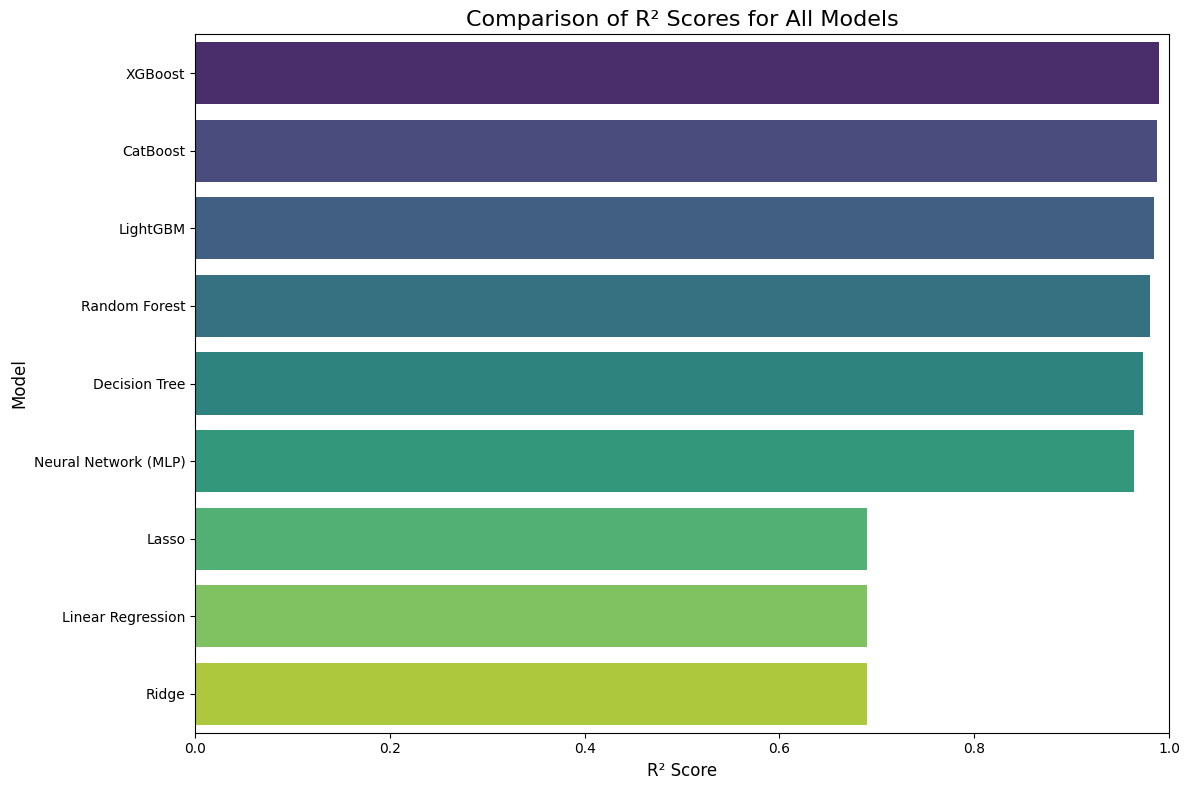

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(x='R2_Score', y='Model', data=scores_df, palette='viridis')
plt.title('Comparison of R² Scores for All Models', fontsize=16)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

Save the Best Model

In [34]:
best_model_name = scores_df.iloc[0]['Model']
best_model_object = trained_models[best_model_name]

pk.dump(best_model_object, open('model.pkl', 'wb'))
pk.dump(preprocessor, open('preprocessor.pkl', 'wb'))
pk.dump(brand_mapping, open('brand_mapping.pkl', 'wb'))

print("The best model was '{}' with an R² score of {:.4f}.".format(best_model_name, scores_df.iloc[0]['R2_Score']))
print("It has been saved to 'model.pkl' along with 'preprocessor.pkl' and 'brand_mapping.pkl'.")

The best model was 'XGBoost' with an R² score of 0.9893.
It has been saved to 'model.pkl' along with 'preprocessor.pkl' and 'brand_mapping.pkl'.
